In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.auto import tqdm
import random
from torch.distributions import Categorical
import torch

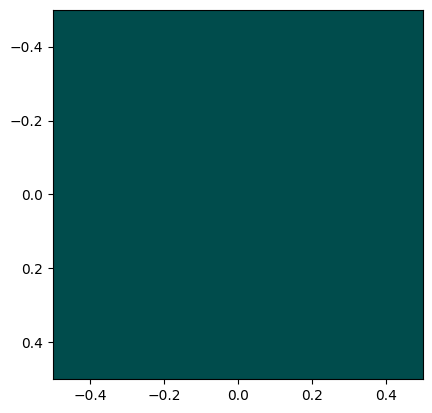

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [3]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self):
      self.num_images = 2000
      self.images = np.random.rand(self.num_images,1,1,3)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      return self.images[idx]


In [4]:
training_dataset = CustomImageDataset()

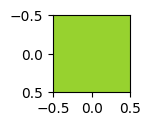

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83])
plt.show()


In [7]:
from torch.utils.data import DataLoader
import torch.nn as nn

train_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True, drop_last=True)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add a batch dimension

    def forward(self, x):
        # Add the positional encodings to the input embeddings
        return x + self.encoding[:, :x.size(1)].detach()

In [191]:
import torch
import torch.nn as nn

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(LearnablePositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, x):
        # Assuming x has shape [batch, len, dim]
        batch_size, seq_len, _ = x.size()

        # Broadcast positional encoding to match the shape of x
        positional_encoding = self.positional_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        
        # Mahdi Code
        #norms = torch.norm(positional_encoding, p=2, dim=2, keepdim=True)
        #positional_encoding = positional_encoding / norms


        # Add positional encoding to the input tensor
        output = x + positional_encoding

        return output

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class SimpleSender(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleSender, self).__init__()
        self.alph_size = alph_size
        # Define your layers or modules here
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=64)
        self.positional_encoding = LearnablePositionalEncoding(64)
        self.rnn = nn.LSTM(64, 64, 1, batch_first=True)
        self.fc3 = nn.Linear(in_features=64, out_features=self.alph_size)


    def forward(self, x, len_message=3):
        # x = [b, 1, 1, 3] -> [b, l, d]
        x = F.leaky_relu(self.fc1(x.flatten(start_dim=1)))
        x = F.leaky_relu(self.fc2(x))
        x = einops.repeat(x, 'b d -> b l d', l = len_message)
        x = self.positional_encoding(x)
        x, _ = self.rnn(x)
        x = self.fc3(x)
        return x


m1 = SimpleSender()
x = torch.randn((20, 1,1, 3))
m1(x).shape

torch.Size([20, 3, 10])

In [194]:
class SimpleReceiver(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleReceiver, self).__init__()
        self.alph_size = alph_size
        ### Image Side
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=16)
        ### Text Side
        self.emb = nn.Embedding(self.alph_size, 16)
        self.fc3 = nn.Linear(in_features=16, out_features=16)
        self.positional_encoding = LearnablePositionalEncoding(16)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=1, batch_first=True, dim_feedforward=16, activation=F.leaky_relu), num_layers=2)



    def forward_image(self, x):
        # x = [b, 1, 1, 3] -> [b, d]
        x = F.leaky_relu(self.fc1(x.flatten(start_dim=1)))
        x = self.fc2(x)
        return x

    def forward_text(self, x, src_key_padding_mask=None):
        # x = [b, l] long Tensor -> [b, d]
        x = F.leaky_relu(self.emb(x))
        x = self.fc3(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # x = x.mean(dim=1)
        x = x[:,0,:]
        return x

In [195]:
def create_mask_after_end_token(input_tensor, end_token_id):
    ### [b, l] -> [b, l]
    # Find the index of the [END] token in each row
    end_token_indices = torch.nonzero(input_tensor == end_token_id)

    # Create a mask tensor of the same shape as the input tensor
    mask_tensor = torch.zeros_like(input_tensor)

    # Set elements after the [END] token index in each row to 1
    for batch_idx, end_idx in end_token_indices:
        mask_tensor[batch_idx, end_idx + 1:] = 1

    return mask_tensor
     

In [196]:
x = torch.randn((20, 1,1, 3))
m1(x)
words = m1(x).argmax(axis=2)
words_mask = create_mask_after_end_token(words, 0).bool()
m2 = SimpleReceiver()
m2.forward_text(words, words_mask).shape

torch.Size([20, 16])

In [197]:
m1 = CustomSender(6)
m1 = SimpleSender(6)
m2 = CustomReceiver(6)
m2 = SimpleReceiver(6)
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3, weight_decay=0e-6)
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3, weight_decay=0e-6)

In [198]:
import time
from torch.distributions import Categorical
import copy

len_message = 3
eaaly_stop_acc = 0.99
max_steps = 3000
log_period_steps = 200
entropy_loss_lambda = 1e-3

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
best_acc = 0
best_model_state = None, None
for iter_num in tqdm(range(max_steps)):
  try:
    batch = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch = next(data_iterator)
    a = batch
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  ###
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  m2_loss.backward()
  m2_optimizer.step()
  ###
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=2), 2, message.unsqueeze(2)))
  rewards = -1*F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]), reduction='none').detach()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  #####
  temp = (1-message_mask.unsqueeze(2)*log_probs)
  temp2 = (returns.unsqueeze(1) * temp.squeeze(2))
  m1_loss = temp2.sum() / ((1-message_mask).sum())
  m1_loss = -torch.mean(returns * log_probs)
  ####
  entropy_loss = -Categorical(F.softmax(message_logits, dim=2)).entropy()
  entropy_loss_masked = (((1-message_mask)*entropy_loss)/((1-message_mask).sum())).sum()
  (m1_loss + entropy_loss_lambda*entropy_loss_masked).backward()
  m1_optimizer.step()
  acc = (1 - similarity_scores.argmax(1)).float().mean()
  acc_list.append(acc)
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(f"step {iter_num} :", acc.item())
    best_acc = acc
    best_model_state = copy.deepcopy(m1.state_dict()), copy.deepcopy(m2.state_dict())
  if acc.item() > eaaly_stop_acc:
    print(f"step {iter_num} :", acc.item())
    break
  if iter_num % log_period_steps == 0:
    print(f"step {iter_num} :",rewards.mean().item(), m1_loss.item(), entropy_loss_masked.item())

m1.load_state_dict(best_model_state[0])
m2.load_state_dict(best_model_state[1])

  0%|          | 0/3000 [00:00<?, ?it/s]

step 0 : 0.5
step 0 : -0.6932412981987 2.8908252716064453e-06 -1.7901917695999146
step 1 : 0.546875
step 9 : 0.5703125


step 28 : 0.59375
step 34 : 0.6171875
step 36 : 0.625
step 44 : 0.65625
step 46 : 0.71875
step 62 : 0.7265625
step 66 : 0.7734375
step 72 : 0.8046875
step 84 : 0.8125
step 95 : 0.8671875
step 117 : 0.8828125
step 129 : 0.8984375
step 146 : 0.90625
step 151 : 0.9140625
step 200 : -0.43313664197921753 2.2413830436107673e-07 -1.7917588949203491
step 266 : 0.921875
step 400 : -0.4693109095096588 -2.5331974029541016e-07 -1.7917588949203491
step 600 : -0.41990309953689575 9.499490261077881e-08 -1.7917591333389282
step 719 : 0.9375
step 800 : -0.49198850989341736 1.4901161193847656e-08 -1.7917591333389282
step 1000 : -0.49480265378952026 -1.8378098332050286e-07 -1.7917594909667969
step 1200 : -0.5311121940612793 6.457170087514896e-08 -1.7917594909667969
step 1400 : -0.4782869219779968 2.731879646944435e-07 -1.7917594909667969
step 1600 : -0.5079416036605835 2.086162567138672e-07 -1.7917596101760864
step 1800 : -0.46978843212127686 -2.9802322387695312e-08 -1.7917593717575073
step 2000 : -0.664

<All keys matched successfully>

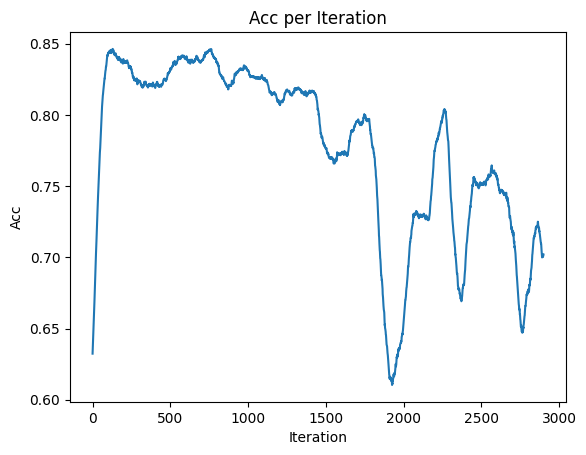

In [199]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()


In [200]:
from collections import defaultdict

for batch in train_dataloader:
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  rewards = 1 - similarity_scores.argmax(1).float()
  print(rewards.mean())

image_dictionary = defaultdict(list)
for i, m in enumerate(message):
  sentence = ""
  for token in m:
    sentence = sentence + str(token.item())
    if sentence[-1] == '0':
      break
  image_dictionary[sentence].append(i)


tensor(0.8594)
tensor(0.8828)
tensor(0.8203)
tensor(0.8203)
tensor(0.8125)
tensor(0.8125)
tensor(0.8594)
tensor(0.8125)
tensor(0.8359)
tensor(0.8047)
tensor(0.8750)
tensor(0.7812)
tensor(0.8516)
tensor(0.7656)
tensor(0.8359)


In [201]:
image_dictionary = dict(sorted(image_dictionary.items(), key=lambda item: item[0]))

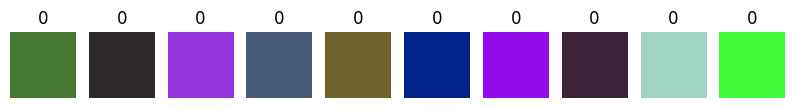

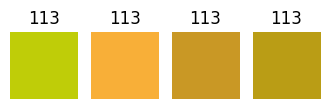

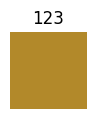

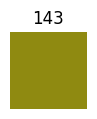

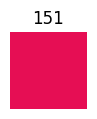

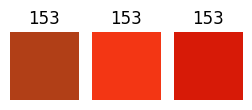

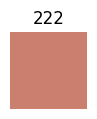

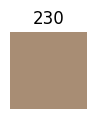

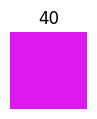

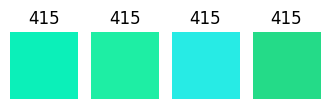

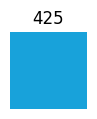

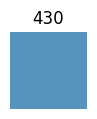

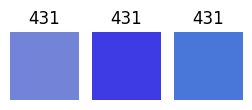

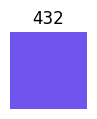

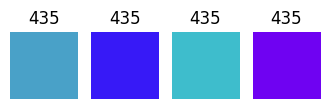

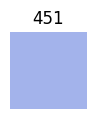

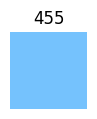

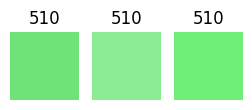

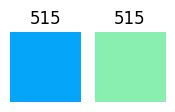

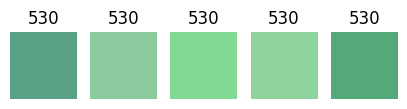

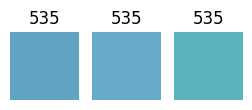

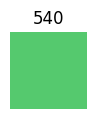

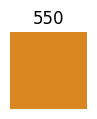

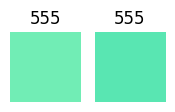

In [202]:
import matplotlib.pyplot as plt

max_image_per_token = 10
for sentence, image_indices in image_dictionary.items():
    image_indices = image_indices[:max_image_per_token]
    num_images = len(image_indices)

    if num_images == 1:
        fig = plt.figure(figsize=(1, 1))
        axs = [plt.subplot(1, 1, 1)]
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    
    for i, image_idx in enumerate(image_indices):
        axs[i].imshow(batch[image_idx])
        axs[i].set_title(f"{sentence}")
        axs[i].axis('off')

    plt.show()
